# Imports

In [2]:
#Basic libraries
import numpy as np
import pandas as pd
import gzip
import json
import sklearn

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Others
from collections import defaultdict
from collections import Counter

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/divyaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/divyaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
csv_path = '../Data/csv_files/'

In [4]:
### Source : http://jmcauley.ucsd.edu/data/amazon/index_2014.html

path = '../Data/'

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
      yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
      df[i] = d
      i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF(path + 'reviews_Movies_and_TV_5.json.gz')

In [5]:
reviews_df = df[["reviewerID", "asin", "reviewText", "summary", "helpful", "overall"]].copy()

In [6]:
reviews_df.head()

,reviewerID,asin,reviewText,summary,helpful,overall
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0


In [7]:
# check if there are any nulls
reviews_df.isnull().sum()

reviewerID    0
asin          0
reviewText    0
summary       0
helpful       0
overall       0
dtype: int64

In [9]:
reviews_df.to_csv(csv_path + 'reviews.csv', index=False)

# Text processing

In [11]:
sws = set(stopwords.words('english'))

# updating stopword list to exclude negative words
sws_updated = sws - set(['hasn',"isn't","wasn't","couldn't","weren",'ain','wasn',"hadn't","shouldn't","not","haven","mustn't","wouldn't","shouldn","needn't","no","nor","mightn't","but","didn","weren't","didn't","shan't","hasn't","won't","couldn'","don't","doesn't","haven't","mightn","hadn","aren't","wouldn'","aren","isn","mustn","doesn",])

punctuations_list = string.punctuation
translator = str.maketrans('', '', punctuations_list)

def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.strip('"')

    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove punctuation
    words = [word.translate(translator) for word in words]
    # Remove stopwords
    cleaned = " ".join([word for word in words if word not in sws_updated])

    return cleaned

reviews_df['reviewText_cleaned'] = reviews_df['reviewText'].apply(clean_text)
reviews_df.to_csv(csv_path + 'cleaned_reviews.csv', index=False)

In [12]:
# updated stopword list
print(sws_updated)

{'myself', 'll', 'himself', 'yourselves', 'above', 'for', 'ourselves', 'couldn', 'why', 'again', 'm', 'herself', 'they', 'what', 'you', 'that', 'same', 'themselves', 'once', 've', 'wouldn', 't', 'between', 'all', 'each', 'are', 'my', 'because', 'some', 'before', 'these', 'be', 'if', 'a', 'through', 'don', 'at', 'of', 'an', 'yours', 'do', 'won', 'was', 'me', 'own', 'during', 'so', 'yourself', 'to', 'in', 'd', 'its', 'it', 'only', 'now', 'she', 'more', 'who', 'o', 'hers', 'their', 'our', 'by', 'too', 'y', "you'd", "she's", 'there', 'ma', 'ours', 'than', 'him', 'other', 'while', 'have', 'can', 'whom', 'we', 'further', 'will', "that'll", 'over', 'your', 'from', "you've", 'under', 'how', 'needn', 'shan', 'which', 'against', 'on', 'both', 'such', 'where', 'should', 'being', 'i', 'below', 'doing', 'when', 'those', 's', 'and', 'out', 'most', 'theirs', 'been', 'her', 'down', "you'll", 'very', 'up', 'just', 'had', 're', "you're", 'until', 'after', 'or', 'as', 'did', 'then', 'am', 'with', 'about'

In [13]:
# Sentiment can be defined using the overall rating provided by the user
def sentiment_basedOn_rating(val):
    if val == 3.0:
        return "neu"
    elif val == 1.0 or val == 2.0:
        return "neg"
    elif val == 4.0 or val == 5.0:
        return "pos"
    else:
        return "none"

In [ ]:
reviews_df = pd.read_csv(csv_path + 'cleaned_reviews.csv')

In [15]:
reviews_df = reviews_df.fillna('')
reviews_df.head()

,reviewerID,asin,reviewText,summary,helpful,overall,reviewText_cleaned
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0,charming version classic dickens tale henry wi...
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0,good but not emotionally moving christmas caro...
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0,dont get wrong winkler wonderful character act...
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0,henry winkler good twist classic story not con...
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0,one best scrooge movies henry winkler outdoes ...


# Sentiment analysis on cleaned review + summary combined

In [16]:
reviews_df['combinedText'] = reviews_df['reviewText_cleaned'] + " " + reviews_df['summary']

In [17]:
analyzer = SentimentIntensityAnalyzer()

reviews_df['sentiment-score'] = reviews_df['combinedText'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [18]:
# Defining sentiment based on the VADER sentiment score
def label_sentiment(score):
    if score >= 0.5:
        return 'pos'
    elif score <= -0.5:
        return 'neg'
    else:
        return 'neu'
    
reviews_df['sentiment-label'] = reviews_df['sentiment-score'].apply(label_sentiment)

In [19]:
reviews_df['sentiment-label'].value_counts()

pos    1282814
neu     212185
neg     202534
Name: sentiment-label, dtype: int64

In [20]:
reviews_df.head()

,reviewerID,asin,reviewText,summary,helpful,overall,reviewText_cleaned,combinedText,sentiment-score,sentiment-label
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0,charming version classic dickens tale henry wi...,charming version classic dickens tale henry wi...,0.9678,pos
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0,good but not emotionally moving christmas caro...,good but not emotionally moving christmas caro...,0.8481,pos
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0,dont get wrong winkler wonderful character act...,dont get wrong winkler wonderful character act...,0.9422,pos
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0,henry winkler good twist classic story not con...,henry winkler good twist classic story not con...,0.7003,pos
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0,one best scrooge movies henry winkler outdoes ...,one best scrooge movies henry winkler outdoes ...,0.8945,pos


Positive sentiment reviews

In [26]:
reviews_df[reviews_df['sentiment-label'] == 'pos'].sort_values(by='sentiment-score', ascending=False)[["combinedText", "overall", "sentiment-score", "sentiment-label"]].head()

,combinedText,overall,sentiment-score,sentiment-label
402683,sound music century fox musical would capture ...,5.0,1.0,pos
956449,proud bradyaddict bradyaddict really easyif kn...,5.0,1.0,pos
520435,yes hobbit nothing say but amizons benifit lov...,5.0,1.0,pos
1199259,essetial starrcade collectionbefore wrestleman...,5.0,1.0,pos
1234065,amazing document recorded midjuly london leona...,5.0,1.0,pos


Negative sentiment reviews

In [27]:
reviews_df[reviews_df['sentiment-label'] == 'neg'].sort_values(by='sentiment-score', ascending=False)[["combinedText", "overall", "sentiment-score", "sentiment-label"]].head()

,combinedText,overall,sentiment-score,sentiment-label
526532,brendan fraser plays uptight cartoonist known ...,3.0,-0.5,neg
823052,expected lot film raving however average good ...,3.0,-0.5,neg
947498,problem series cast bodybuilder velour leotard...,1.0,-0.5,neg
606051,still dont get good movie awful regret paying ...,1.0,-0.5,neg
105325,dammit keep pulling kevin costner deals big bi...,3.0,-0.5,neg


Neutral sentiment reviews

In [28]:
reviews_df[reviews_df['sentiment-label'] == 'neu'].sort_values(by='sentiment-score', ascending=False)[["combinedText", "overall", "sentiment-score", "sentiment-label"]].head()

,combinedText,overall,sentiment-score,sentiment-label
549624,huge fan l montgomerys work since elevenyear o...,1.0,0.4999,neu
698321,given delicatessen one best films ever made pl...,3.0,0.4999,neu
1681349,love along followups riff trax cinematic titan...,5.0,0.4999,neu
1382698,dancepilatesballetfusion girl but need lose we...,3.0,0.4999,neu
961514,dama agatha not enjoy films not faithful adapt...,5.0,0.4999,neu


In [29]:
reviews_df.to_csv(csv_path + 'combinedText_with_sentiment.csv', index=False)

In [ ]:
reviews_df = pd.read_csv(csv_path + 'combinedText_with_sentiment.csv')

In [31]:
pos_reviews = reviews_df[reviews_df["sentiment-label"]=="pos"].dropna()
neg_reviews = reviews_df[reviews_df["sentiment-label"]=="neg"].dropna()
neu_reviews = reviews_df[reviews_df["sentiment-label"]=="neu"].dropna()

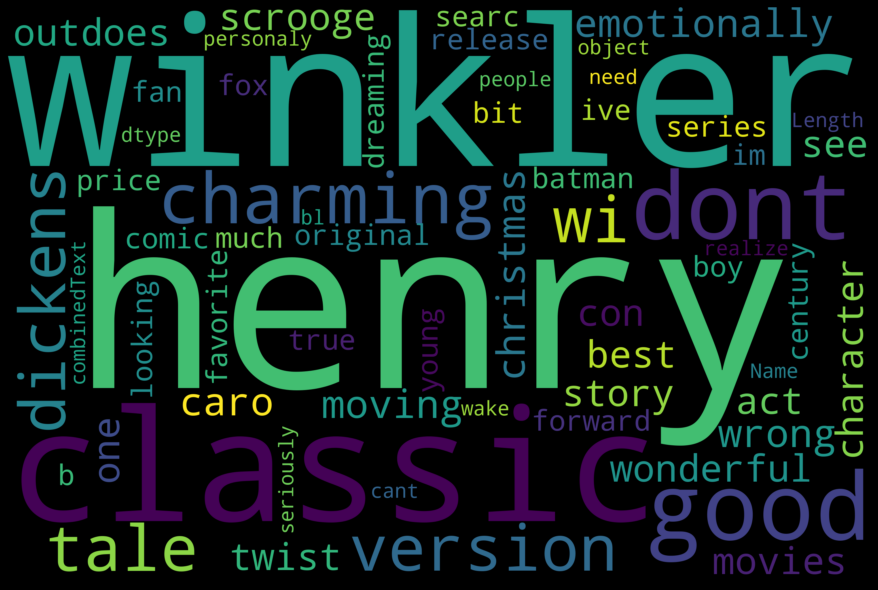

In [32]:
text = pos_reviews["combinedText"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

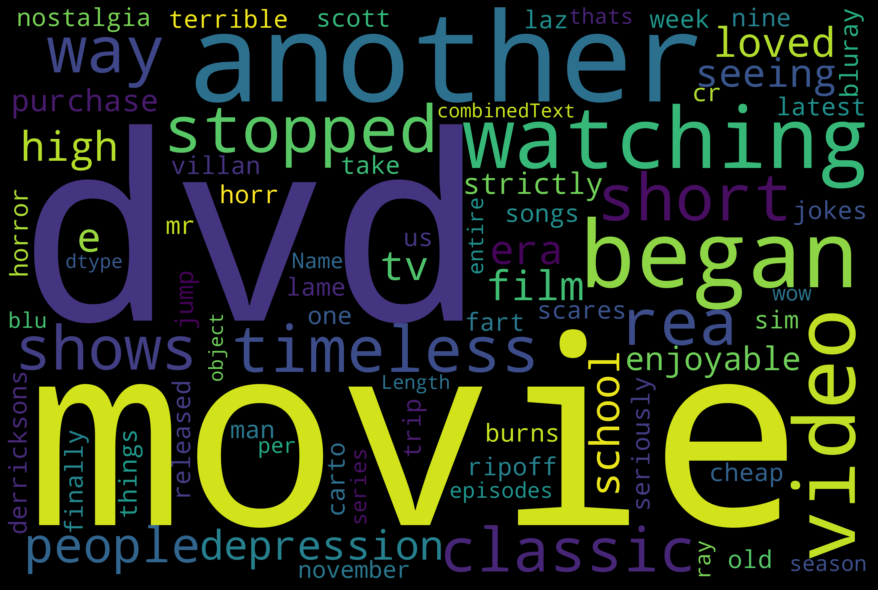

In [33]:
text = neg_reviews["combinedText"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

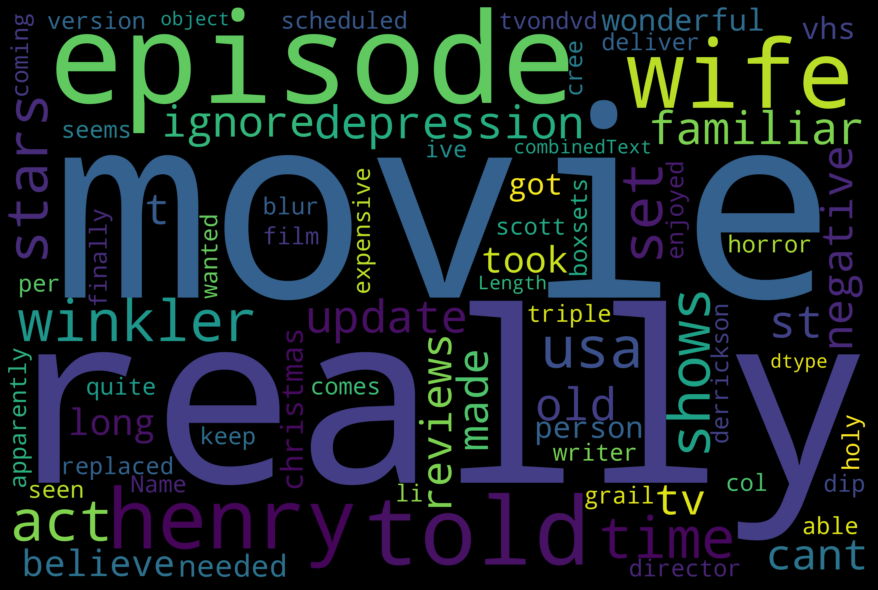

In [34]:
text = neu_reviews["combinedText"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [35]:
rating_sentiment = reviews_df['overall'].apply(sentiment_basedOn_rating)

              precision    recall  f1-score   support

         pos       0.84      0.84      0.84   1289602
         neg       0.41      0.40      0.40    206629
         neu       0.18      0.19      0.19    201302

    accuracy                           0.71   1697533
   macro avg       0.48      0.48      0.48   1697533
weighted avg       0.71      0.71      0.71   1697533



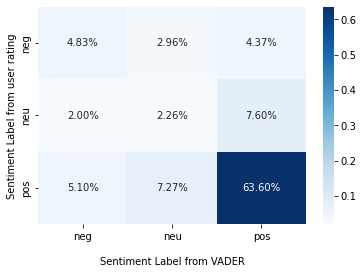

In [36]:
# Source : https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
cm = metrics.confusion_matrix(rating_sentiment, reviews_df['sentiment-label'])

print(classification_report(rating_sentiment, reviews_df['sentiment-label'], labels=['pos','neg','neu']))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel('\nSentiment Label from VADER')
ax.set_ylabel('Sentiment Label from user rating');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['neg', 'neu','pos'])
ax.yaxis.set_ticklabels(['neg', 'neu','pos'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
rating_sentiment.value_counts()

pos    1289602
neg     206629
neu     201302
Name: overall, dtype: int64

In [38]:
reviews_df['sentiment-label'].value_counts()

pos    1282814
neu     212185
neg     202534
Name: sentiment-label, dtype: int64

# Sentiment Analysis on summary alone

In [39]:
reviews_df2 = reviews_df.drop(columns=['sentiment-score', 'sentiment-label']).copy()
del reviews_df

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer2 = SentimentIntensityAnalyzer()

def label_sentiment(score):
    if score >= 0.5:
        return 'pos'
    elif score <= -0.5:
        return 'neg'
    else:
        return 'neu'
        
reviews_df2['sentiment-score'] = reviews_df2['summary'].apply(lambda x:analyzer2.polarity_scores(x)['compound'])

reviews_df2['sentiment-label'] = reviews_df2['sentiment-score'].apply(label_sentiment)

In [41]:
reviews_df2.head()

,reviewerID,asin,reviewText,summary,helpful,overall,reviewText_cleaned,combinedText,sentiment-score,sentiment-label
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0,charming version classic dickens tale henry wi...,charming version classic dickens tale henry wi...,0.4404,neu
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0,good but not emotionally moving christmas caro...,good but not emotionally moving christmas caro...,0.2382,neu
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0,dont get wrong winkler wonderful character act...,dont get wrong winkler wonderful character act...,0.7712,pos
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0,henry winkler good twist classic story not con...,henry winkler good twist classic story not con...,0.4404,neu
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0,one best scrooge movies henry winkler outdoes ...,one best scrooge movies henry winkler outdoes ...,0.6369,pos


In [42]:
reviews_df2['sentiment-label'].value_counts()

neu    1097174
pos     507486
neg      92873
Name: sentiment-label, dtype: int64

In [43]:
reviews_df2.to_csv(csv_path + 'summary_sentiment.csv', index=False)

In [ ]:
reviews_df2 = pd.read_csv(csv_path + 'summary_sentiment.csv')

In [44]:
reviews_df2.head()

,reviewerID,asin,reviewText,summary,helpful,overall,reviewText_cleaned,combinedText,sentiment-score,sentiment-label
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0,charming version classic dickens tale henry wi...,charming version classic dickens tale henry wi...,0.4404,neu
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0,good but not emotionally moving christmas caro...,good but not emotionally moving christmas caro...,0.2382,neu
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0,dont get wrong winkler wonderful character act...,dont get wrong winkler wonderful character act...,0.7712,pos
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0,henry winkler good twist classic story not con...,henry winkler good twist classic story not con...,0.4404,neu
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0,one best scrooge movies henry winkler outdoes ...,one best scrooge movies henry winkler outdoes ...,0.6369,pos


Positive sentiment reviews

In [45]:
reviews_df2[reviews_df2['sentiment-label'] == 'pos'].sort_values(by='sentiment-score', ascending=False)[["summary", "overall", "sentiment-score", "sentiment-label"]].head()

,summary,overall,sentiment-score,sentiment-label
403039,"Great, Great, Great, Great, Great, Great, Grea...",5.0,0.9954,pos
1638310,Love Love Love Love Love Love Love Love Love A...,5.0,0.9911,pos
414190,GREAT GREAT GREAT GREAT GREAT GREAT GREAT GREAT,5.0,0.9880,pos
1448663,LOVE LOVE LOVE LOVE LOVE LOVE LOVE,5.0,0.9854,pos
1450862,We need more beautiful movies like this! this...,5.0,0.9813,pos


Negative sentiment reviews

In [46]:
reviews_df2[reviews_df2['sentiment-label'] == 'neg'].sort_values(by='sentiment-score', ascending=False)[["summary", "overall", "sentiment-score", "sentiment-label"]].head()

,summary,overall,sentiment-score,sentiment-label
904640,No Redeeming Value,1.0,-0.5,neg
611305,I can't hardly believe how bad it is.,1.0,-0.5,neg
1692516,NO WAY PLAY,1.0,-0.5,neg
1655104,No redeeming value,1.0,-0.5,neg
1609082,No Redeeming Value Whatsoever,1.0,-0.5,neg


Neutral sentiment reviews

In [47]:
reviews_df2[reviews_df2['sentiment-label'] == 'neu'].sort_values(by='sentiment-score', ascending=False)[["summary", "overall", "sentiment-score", "sentiment-label"]].head()

,summary,overall,sentiment-score,sentiment-label
176820,"3.5 stars - very stupid, but also very funny!",3.0,0.4998,neu
1105696,"Nothing funnier than fat people, I love T.P.!",5.0,0.4997,neu
1023594,"Disappointed at the Box Office, but True to Su...",3.0,0.4997,neu
1550059,Treasured Masterpiece in Shoddy Audio-visual q...,3.0,0.4997,neu
1602315,"Beautiful to Look at, If Not Compelling as a D...",3.0,0.4997,neu


In [48]:
pos_reviews = reviews_df2[reviews_df2["sentiment-label"] == "pos"].dropna()
neg_reviews = reviews_df2[reviews_df2["sentiment-label"] == "neg"].dropna()
neu_reviews = reviews_df2[reviews_df2["sentiment-label"] == "neu"].dropna()

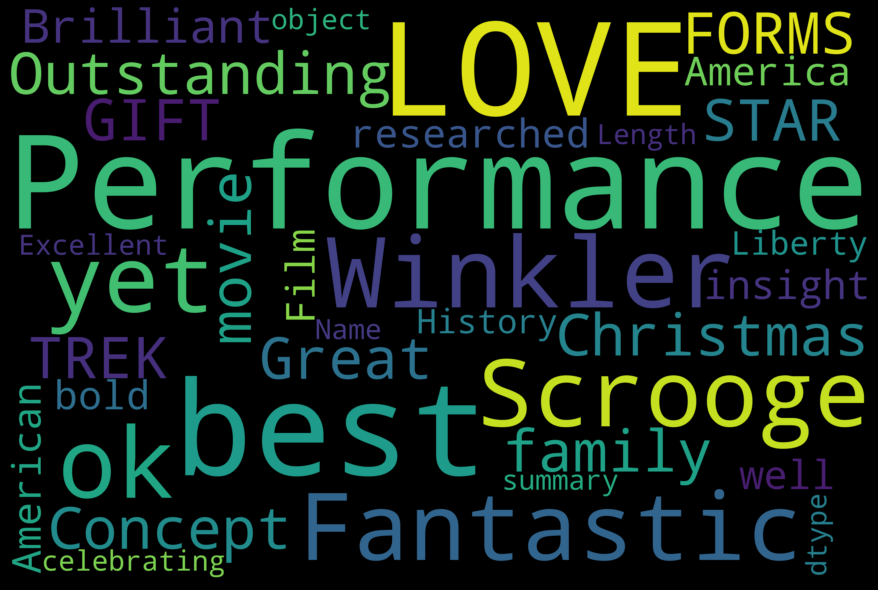

In [49]:
text = pos_reviews["summary"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

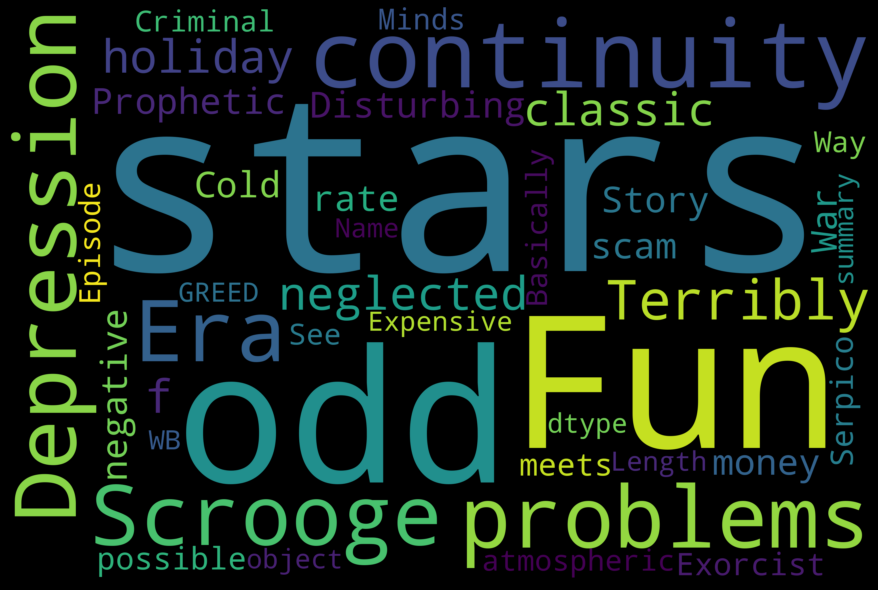

In [50]:
text = neg_reviews["summary"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

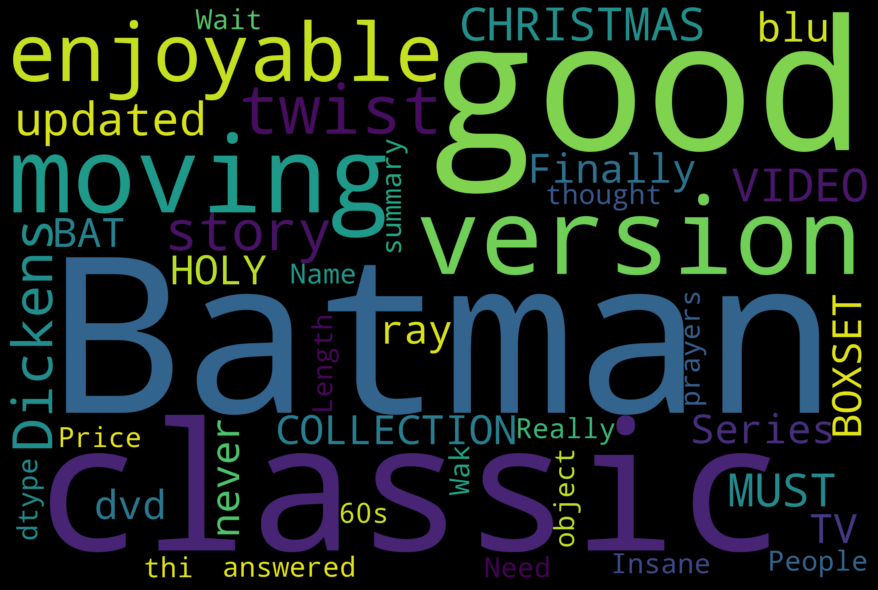

In [51]:
text = neu_reviews["summary"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [52]:
rating_sentiment2 = reviews_df2['overall'].apply(sentiment_basedOn_rating)

              precision    recall  f1-score   support

         pos       0.93      0.36      0.52   1289602
         neg       0.39      0.18      0.24    206629
         neu       0.15      0.80      0.25    201302

    accuracy                           0.39   1697533
   macro avg       0.49      0.45      0.34   1697533
weighted avg       0.77      0.39      0.46   1697533



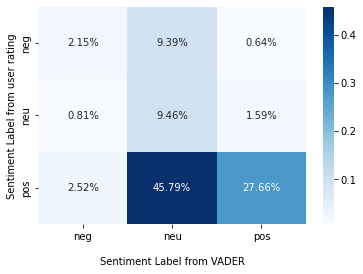

In [53]:
# Source : https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
cm = metrics.confusion_matrix(rating_sentiment2, reviews_df2['sentiment-label'])

print(classification_report(rating_sentiment2, reviews_df2['sentiment-label'], labels=['pos','neg','neu']))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel('\nSentiment Label from VADER')
ax.set_ylabel('Sentiment Label from user rating');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['neg', 'neu','pos'])
ax.yaxis.set_ticklabels(['neg', 'neu','pos'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Sentiment Analysis on cleaned review alone

In [54]:
reviews_df3 = reviews_df2.drop(columns=['sentiment-score', 'sentiment-label']).copy()
del reviews_df2

In [55]:
analyzer3 = SentimentIntensityAnalyzer()

def label_sentiment(score):
    if score >= 0.5:
        return 'pos'
    elif score <= -0.5:
        return 'neg'
    else:
        return 'neu'
        
reviews_df3['sentiment-score'] = reviews_df3['reviewText_cleaned'].apply(lambda x:analyzer3.polarity_scores(x)['compound'])
reviews_df3['sentiment-label'] = reviews_df3['sentiment-score'].apply(label_sentiment)

In [56]:
reviews_df3.head()

,reviewerID,asin,reviewText,summary,helpful,overall,reviewText_cleaned,combinedText,sentiment-score,sentiment-label
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0,charming version classic dickens tale henry wi...,charming version classic dickens tale henry wi...,0.9584,pos
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0,good but not emotionally moving christmas caro...,good but not emotionally moving christmas caro...,0.6542,pos
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0,dont get wrong winkler wonderful character act...,dont get wrong winkler wonderful character act...,0.8480,pos
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0,henry winkler good twist classic story not con...,henry winkler good twist classic story not con...,0.2382,neu
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0,one best scrooge movies henry winkler outdoes ...,one best scrooge movies henry winkler outdoes ...,0.6059,pos


In [57]:
reviews_df3['sentiment-label'].value_counts()

pos    1231714
neu     270580
neg     195239
Name: sentiment-label, dtype: int64

In [58]:
reviews_df3.to_csv(csv_path + 'reviewText_cleaned_sentiment.csv', index=False)

In [ ]:
reviews_df3 = pd.read_csv(csv_path + 'reviewText_cleaned_sentiment.csv')

Positive sentiment reviews

In [59]:
reviews_df3[reviews_df3['sentiment-label'] == 'pos'].sort_values(by='sentiment-score', ascending=False)[["summary", "overall", "sentiment-score", "sentiment-label"]].head()

,summary,overall,sentiment-score,sentiment-label
1453158,"More crashes, more falls, more intensity, less...",3.0,1.0,pos
1696772,"""There's no place like home.""",5.0,1.0,pos
1262143,A massive collection of moments...,5.0,1.0,pos
1010469,Romantic Magic,5.0,1.0,pos
1333240,"THE HOLY ""BEAVER"" GRAIL",5.0,1.0,pos


Negative sentiment reviews

In [60]:
reviews_df3[reviews_df3['sentiment-label'] == 'neg'].sort_values(by='sentiment-score', ascending=False)[["summary", "overall", "sentiment-score", "sentiment-label"]].head()

,summary,overall,sentiment-score,sentiment-label
402463,See Biddie topless!,1.0,-0.5,neg
894854,MacGyver,5.0,-0.5,neg
96000,Beetlejuice ... Beetlejuice ... Beetlejuice ...,5.0,-0.5,neg
947498,No. Just no.,1.0,-0.5,neg
589975,What a waste,2.0,-0.5,neg


Neutral sentiment reviews

In [61]:
reviews_df3[reviews_df3['sentiment-label'] == 'neu'].sort_values(by='sentiment-score', ascending=False)[["summary", "overall", "sentiment-score", "sentiment-label"]].head()

,summary,overall,sentiment-score,sentiment-label
1277867,Good anime,4.0,0.4999,neu
555796,"When the System Plays at Fascism, Outsiders wi...",5.0,0.4999,neu
1370552,Don't Bother,1.0,0.4999,neu
1681349,The coolest show ever was totally uncool in Un...,5.0,0.4999,neu
1096637,Fun for adults too,4.0,0.4999,neu


In [62]:
pos_reviews = reviews_df3[reviews_df3["sentiment-label"]=="pos"].dropna()
neg_reviews = reviews_df3[reviews_df3["sentiment-label"]=="neg"].dropna()
neu_reviews = reviews_df3[reviews_df3["sentiment-label"]=="neu"].dropna()

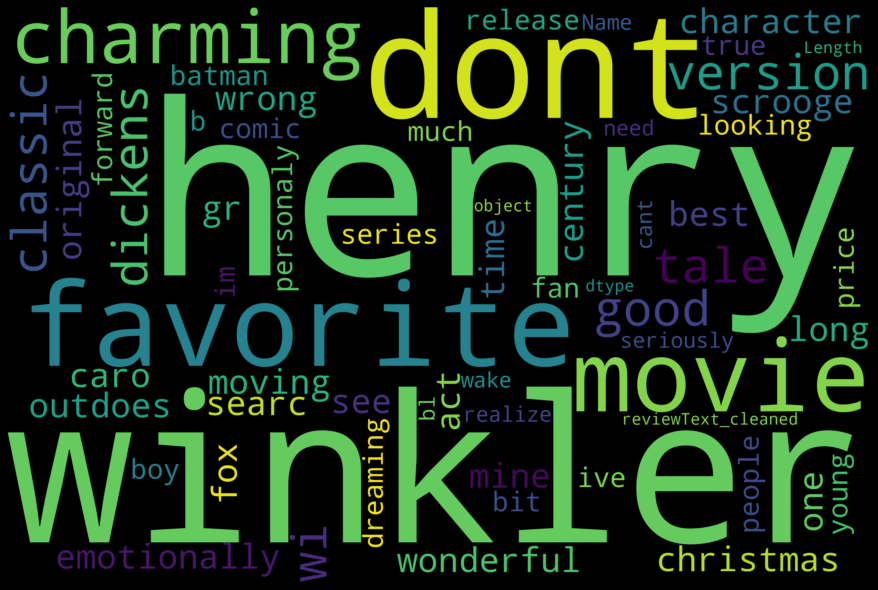

In [63]:
text = pos_reviews["reviewText_cleaned"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

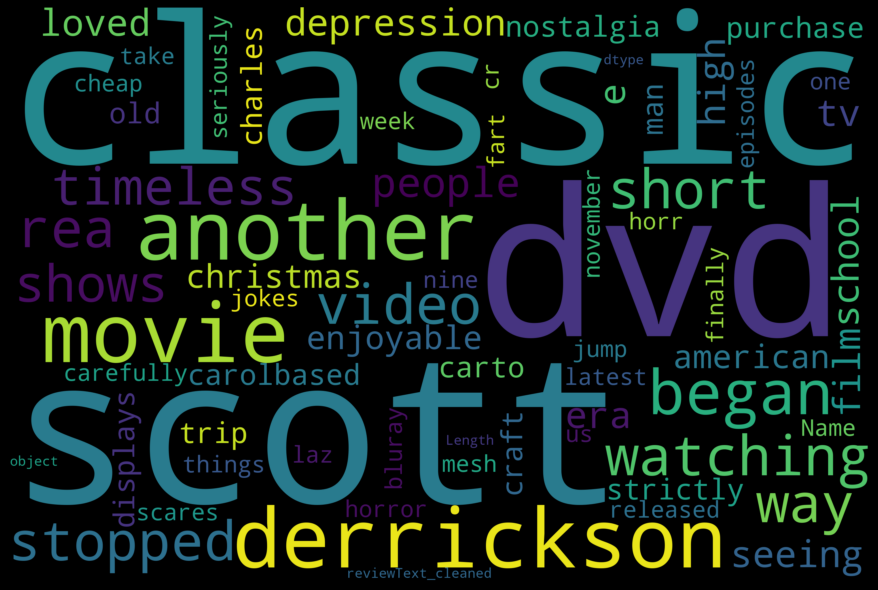

In [64]:
text = neg_reviews["reviewText_cleaned"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

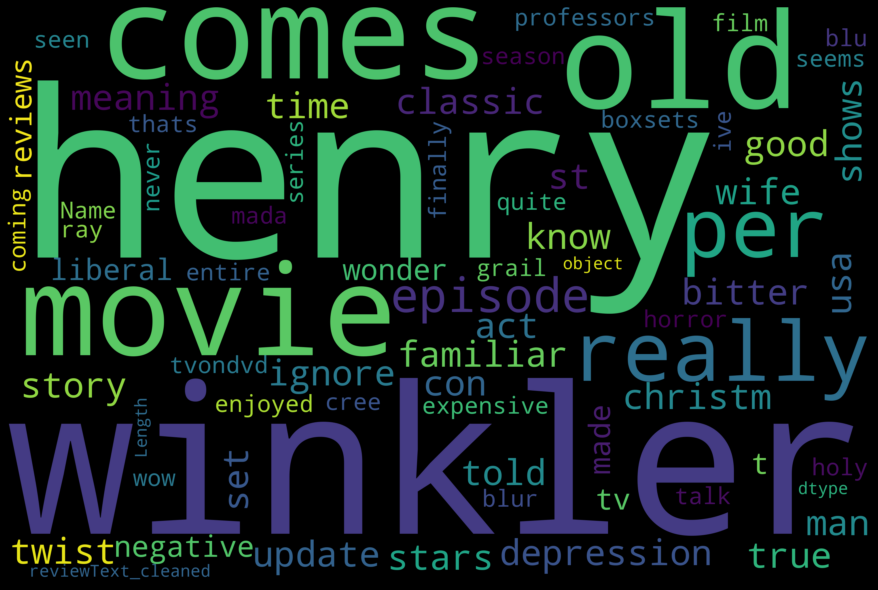

In [65]:
text = neu_reviews["reviewText_cleaned"]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [66]:
rating_sentiment3 = reviews_df3['overall'].apply(sentiment_basedOn_rating)

              precision    recall  f1-score   support

         pos       0.84      0.80      0.82   1289602
         neg       0.37      0.35      0.36    206629
         neu       0.16      0.22      0.19    201302

    accuracy                           0.68   1697533
   macro avg       0.46      0.46      0.45   1697533
weighted avg       0.70      0.68      0.69   1697533



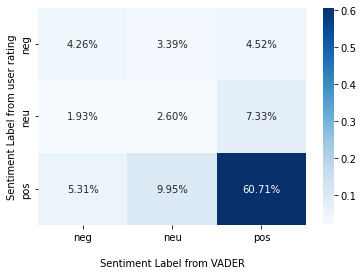

In [67]:
# Source : https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

cm = metrics.confusion_matrix(rating_sentiment3, reviews_df3['sentiment-label'])

print(classification_report(rating_sentiment3, reviews_df3['sentiment-label'], labels=['pos','neg','neu']))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel('\nSentiment Label from VADER')
ax.set_ylabel('Sentiment Label from user rating');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['neg', 'neu','pos'])
ax.yaxis.set_ticklabels(['neg', 'neu','pos'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [68]:
rating_sentiment3.value_counts()

pos    1289602
neg     206629
neu     201302
Name: overall, dtype: int64

In [69]:
reviews_df3['sentiment-label'].value_counts()

pos    1231714
neu     270580
neg     195239
Name: sentiment-label, dtype: int64